# Simple Character-level Language Model using LSTM
2017-04-11 jkang  
Python3.5  
TensorFlow1.0.1  
  
- input:  &nbsp;&nbsp;'hello_world_good_morning_see_you_hello_grea'  
- output: 'ello_world_good_morning_see_you_hello_great'  

### Reference:  
- https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py  
- https://github.com/aymericdamien/TensorFlow-Examples
- https://hunkim.github.io/ml/  

### Comment:  
- 단어 단위가 아닌 문자 단위로 훈련함
- 하나의 example만 훈련에 사용함
- Cell의 종류는 BasicLSTMCell을 사용함 (첫번째 Reference 참조)
- dynamic_rnn방식 사용 (기존 tf.nn.rnn보다 더 시간-계산 효율적이라고 함)
- AdamOptimizer를 사용

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Input/Ouput data
char_raw = 'hello_world_good_morning_see_you_hello_great'
char_list = sorted(list(set(char_raw)))
char_to_idx = {c: i for i, c in enumerate(char_list)}
idx_to_char = {i: c for i, c in enumerate(char_list)}
char_data = [char_to_idx[c] for c in char_raw]
char_data_one_hot = tf.one_hot(char_data, depth=len(
    char_list), on_value=1., off_value=0., axis=1, dtype=tf.float32)
char_input = char_data_one_hot[:-1, :]  # 'hello_world_good_morning_see_you_hello_grea'
char_output = char_data_one_hot[1:, :]  # 'ello_world_good_morning_see_you_hello_great'
with tf.Session() as sess:
    char_input = char_input.eval()
    char_output = char_output.eval()

In [2]:
# Learning parameters
learning_rate = 0.001
max_iter = 1000

# Network Parameters
n_input_dim = char_input.shape[1]
n_input_len = char_input.shape[0]
n_output_dim = char_output.shape[1]
n_output_len = char_output.shape[0]
n_hidden = 100

# TensorFlow graph
# (batch_size) x (time_step) x (input_dimension)
x_data = tf.placeholder(tf.float32, [1, None, n_input_dim])
# (batch_size) x (time_step) x (output_dimension)
y_data = tf.placeholder(tf.float32, [1, None, n_output_dim])

# Parameters
weights = {
    'out': tf.Variable(tf.truncated_normal([n_hidden, n_output_dim]))
}
biases = {
    'out': tf.Variable(tf.truncated_normal([n_output_dim]))
}

In [3]:
def RNN(x, weights, biases):
    cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0) # Make RNNCell
    outputs, states = tf.nn.dynamic_rnn(cell, x, time_major=False, dtype=tf.float32)
    '''
    **Notes on tf.nn.dynamic_rnn**

    - 'x' can have shape (batch)x(time)x(input_dim), if time_major=False or 
                         (time)x(batch)x(input_dim), if time_major=True
    - 'outputs' can have the same shape as 'x'
                         (batch)x(time)x(input_dim), if time_major=False or 
                         (time)x(batch)x(input_dim), if time_major=True
    - 'states' is the final state, determined by batch and hidden_dim
    '''
    
    # outputs[-1] is outputs for the last example in the mini-batch
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

def softmax(x):
    rowmax = np.max(x, axis=1)
    x -= rowmax.reshape((x.shape[0] ,1)) # for numerical stability
    x = np.exp(x)
    sum_x = np.sum(x, axis=1).reshape((x.shape[0],1))
    return x / sum_x

pred = RNN(x_data, weights, biases)
cost = tf.reduce_mean(tf.squared_difference(pred, y_data))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [4]:
# Learning
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x_train = char_input.reshape((1, char_input.shape[0], n_input_dim))
    y_train = char_output.reshape((1, char_output.shape[0], n_output_dim))
    for i in range(max_iter):
        _, loss, p = sess.run([optimizer, cost, pred],
                              feed_dict={x_data: x_train, y_data: y_train})
        if i == (max_iter-1):
            pred_act = softmax(p)
        if (i+1) % 100 == 0:
            pred_out = np.argmax(p, axis=1)
            accuracy = np.sum(char_data[1:] == pred_out)/n_output_len*100
            print('Epoch:{:>4}/{},'.format(i+1,max_iter),
                  'Cost:{:.4f},'.format(loss), 
                  'Acc:{:>.1f},'.format(accuracy),
                  'Predict:', ''.join([idx_to_char[i] for i in pred_out]))

Epoch: 100/1000, Cost:0.0392, Acc:83.7, Predict: gglo_world_goo__morning_seeeyou_hello_woelt
Epoch: 200/1000, Cost:0.0179, Acc:97.7, Predict: gllo_world_good_morning_see_you_hello_great
Epoch: 300/1000, Cost:0.0093, Acc:100.0, Predict: ello_world_good_morning_see_you_hello_great
Epoch: 400/1000, Cost:0.0047, Acc:100.0, Predict: ello_world_good_morning_see_you_hello_great
Epoch: 500/1000, Cost:0.0027, Acc:100.0, Predict: ello_world_good_morning_see_you_hello_great
Epoch: 600/1000, Cost:0.0017, Acc:100.0, Predict: ello_world_good_morning_see_you_hello_great
Epoch: 700/1000, Cost:0.0012, Acc:100.0, Predict: ello_world_good_morning_see_you_hello_great
Epoch: 800/1000, Cost:0.0016, Acc:100.0, Predict: ello_world_good_morning_see_you_hello_great
Epoch: 900/1000, Cost:0.0011, Acc:100.0, Predict: ello_world_good_morning_see_you_hello_great
Epoch:1000/1000, Cost:0.0005, Acc:100.0, Predict: ello_world_good_morning_see_you_hello_great


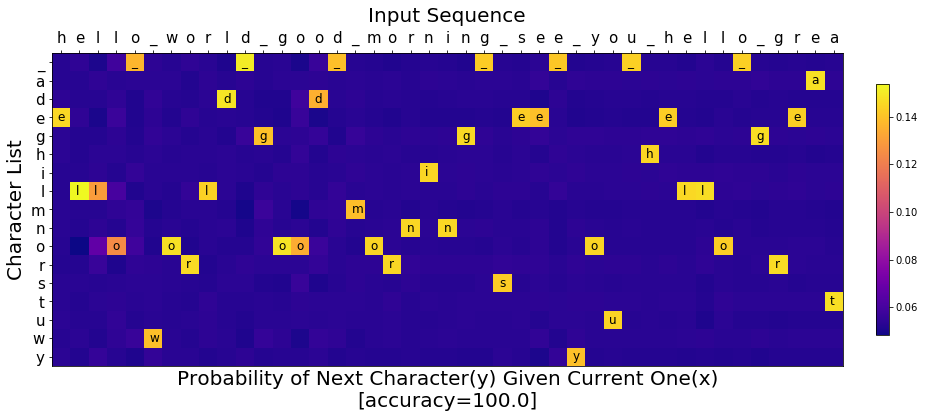

In [5]:
# Probability plot
fig, ax = plt.subplots()
fig.set_size_inches(15,20)
plt.title('Input Sequence', y=1.08, fontsize=20)
plt.xlabel('Probability of Next Character(y) Given Current One(x)'+
           '\n[accuracy={:.1f}]'.format(accuracy), 
           fontsize=20, y=1.5)
plt.ylabel('Character List', fontsize=20)
plot = plt.imshow(pred_act.T, cmap=plt.get_cmap('plasma'))
fig.colorbar(plot, fraction=0.015, pad=0.04)
plt.xticks(np.arange(len(char_data)-1), list(char_raw)[:-1], fontsize=15)
plt.yticks(np.arange(len(char_list)), [idx_to_char[i] for i in range(len(char_list))], fontsize=15)
ax.xaxis.tick_top()

# Annotate
for i, idx in zip(range(len(pred_out)), pred_out):
    annotation = idx_to_char[idx]
    ax.annotate(annotation, xy=(i-0.2, idx+0.2), fontsize=12)
    
plt.show()